Please complete the `NotImplemented` parts of the code cells and write your answers in the markdown cells designated for your response to any questions asked. The tag `# AUTOGRADED` (all caps, with a space after `#`) should be at the beginning of each autograded code cell, so make sure that you do not change that. You are also not allowed to import any new package other than the ones already imported. Doing so will prevent the autograder from grading your code.

For the code submission, run the last cell in the notebook to create the submission zip file. If you are working in Colab, make sure to download and then upload a copy of the completed notebook itself to its working directory to be included in the zip file. Finally, submit the zip file to Gradescope.

After you finish the assignment and fill in your code and response where needed (all cells should have been run), save the notebook as a PDF using the `jupyter nbconvert --to pdf HW5.ipynb` command (via a notebook code cell or the command line directly) and submit the PDF to Gradescope under the PDF submission item. If you cannot get this to work locally, you can upload the notebook to Google Colab and create the PDF there. You can find the notebook containing the instruction for this on Canvas.

If you are running the notebook locally, make sure you have created a virtual environment (using `conda` for example) and have the proper packages installed. We are working with `python=3.10` and `torch>=2`.

Files to be included in submission:

- `HW5.ipynb`
- `model_config.yaml`
- `train_config.yaml`
- `state_dict.pt`

In [6]:
"""
DO NOT ADD ANY ADDITIONAL IMPORTS IN THE NOTEBOOK.
"""
import os
from typing import Sequence, Dict, Union
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset

try:
    import torch_geometric as gtorch
except ImportError:
    os.system('pip install torch_geometric -qq')
    os.system('pip install torch-scatter -qq')
    import torch_geometric as gtorch

import torch_geometric.data as gdata
from torch_geometric import nn as gnn
from torch_geometric.loader import DataLoader as gDataLoader

from HW5_utils import Tracker, print_tensor_info # just in case you need it
from HW5_utils import test_graph_convolution, save_yaml, load_yaml, zip_files, train

if torch.cuda.is_available():
    Device = 'cuda'
elif torch.backends.mps.is_available():
    Device = 'mps'
else:
    Device = 'cpu'

print(f'Device is {Device}')

Device is cpu


# Implement the Graph Convolutional Operator (30)

Your first task is to implement the graph convolution operator that is calculated in the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html) layer, but __only using `numpy`__. You can see the mathematical definition in the paper and in the online documentation. Basically, you are going to implement the following:

$$ 
X' = D^{-1/2} A D^{-1/2} X \Theta
$$

First you should get more familiar with how a graph is defined. In a general graph, edges have directions, and information flows from the source node to the target node. In our code, edges are defined by `edge_index`, which is of the shape `(2, num_edges)`. Each column corresponds to one edge and has two elements: the first (at index `0`) is the source node's index `j` and the second (at index `1`) is the target node's index `i`. This makes nodes `j` a neighbor of node `i`, or in mathematical notation $j\in\mathcal{N}(i)$. In the adjacency matrix, `A[i, j]` should be $e_{j, i}$ (the edge weight) if `j` is a neighbor of `i` and $0$ otherwise. You have to create $A$ from `edge_index` and `edge_weights` (without `for` loops).

If `add_self_loops=True`, you have to modify $A$ so there is an edge with weight 1 connecting each node to itself.

$\hat{D}^{-1/2}$ is a diagonal matrix (zero on non-diagonal elements), with the $i$-th element on its diagonal being $d_i^{-1/2}$ where $d_i=\sum_{j\in\mathcal{N}(i)} e_{j, i}$. You can calculate this matrix from the adjacency matrix $A$.

**REMEMBER**: `for` loops make things slow. Therefore, there is a penalty of `-5` for each unnecessary `for` loop. An essential skill you have to learn is to _vectorize_ your operations and calculations, which basically means to avoid using `for` loops and instead make use of parallel computing provided by functions in libraries like `numpy` and `torch`. You can look back at recitation zero to see how you can index tensors or arrays with other tensors or arrays.

You can test your function by comparing it to the output of the actual `GCNConv` layer from `gtorch`. The test function is provided to you, so you can try as much as you want until you get it right.

In [7]:
# AUTOGRADED

# Only numpy allowed
def graph_convolution(
        x: np.ndarray, # shape: (num_nodes, in_channels), dtype: np.float32
        edge_index: np.ndarray, # shape: (2, num_edges), dtype: np.int64
        edge_weights: np.ndarray, # shape: (num_edges,), dtype: np.float32
        theta: np.ndarray, # shape: (in_channels, out_channels), dtype: np.float32
        add_self_loops: bool = True,
        ) -> np.ndarray: # shape: (num_nodes, out_channels), dtype: np.float32
        
    
    num_nodes = x.shape[0]
    
    # Create adjacency matrix A
    A = np.zeros((num_nodes, num_nodes), dtype=np.float32)
    A[edge_index[1], edge_index[0]] = edge_weights  # A[i, j] = e_{j, i}
    
    # Add self-loops
    if add_self_loops:
        A += np.eye(num_nodes, dtype=np.float32)
    
    # Compute degree matrix D
    D = np.sum(A, axis=1)  # Sum over rows to get degree of each node
    D_inv_sqrt = np.diag(1.0 / np.sqrt(D + 1e-8))  # Avoid division by zero
    
    # Compute normalized adjacency matrix: D^(-1/2) A D^(-1/2)
    A_norm = D_inv_sqrt @ A @ D_inv_sqrt
    
    # Perform convolution operation
    x_prime = A_norm @ x @ theta
    
    return x_prime


In [4]:
"""
Test your code.
"""
test_graph_convolution(graph_convolution, num_tests=5, show_failed_edge_index=True)

All tests passed!


# Implement and train a GNN (70)
Your second task in this assignment is to define and train a model to predict log solubility of molecules in water. You have to define a model and achieve a low enough loss by finding a good model and training it. The dataset class is provided to you. Use it to inspect the data and find out the information you need to define your model.

In [8]:
class GraphDataset(Dataset):
    
    def __init__(
            self,
            data_path: str,
            ):
        super().__init__()
        np_data = np.load(data_path, allow_pickle=True)

        self.samples = []
        for i, (x, edge_index, edge_attr, y) in enumerate(np_data):
            self.samples.append(
                gdata.Data(
                    x = torch.tensor(np.array(x), dtype=torch.float32),
                    edge_index = torch.tensor(np.array(edge_index), dtype=torch.long),
                    edge_attr = torch.tensor(np.array(edge_attr), dtype=torch.float32),
                    y = torch.tensor(np.array(y).reshape(1, 1), dtype=torch.float32)
                )
            )

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

In [17]:
"""
Inspect the dataset. You can also create a gDataLoader to inspect the batched data.
"""
my_dataset = GraphDataset('data/train.npy')

# Inspect the dataset
print(f"Number of graphs in dataset: {len(my_dataset)}")
print(f"Sample graph data: {my_dataset[0]}")  # Print first sample

# Create a DataLoader
batch_size = 32
train_loader = gDataLoader(my_dataset, batch_size=batch_size, shuffle=True)

# Inspect a batch
batch = next(iter(train_loader))
print(f"Batch data: {batch}")
print(my_dataset[0])  # Inspect the first graph


Number of graphs in dataset: 904
Sample graph data: Data(x=[32, 37], edge_index=[2, 68], edge_attr=[68, 6], y=[1, 1])
Batch data: DataBatch(x=[382, 37], edge_index=[2, 780], edge_attr=[780, 6], y=[32, 1], batch=[382], ptr=[33])
Data(x=[32, 37], edge_index=[2, 68], edge_attr=[68, 6], y=[1, 1])


## Define your Model (60)

Implement a model to predict the log solubility of a molecule which is represented as a graph. This is a graph regression task, so you need one output per sample graph. Your model's forward method should process batched graphs. Define some [graph convolution layers](https://pytorch-geometric.readthedocs.io/en/2.5.1/modules/nn.html#convolutional-layers) for node-level processing and message passing, then use a global pooling function, and the rest is like normal fully connected networks. Don't forget nonlinear activation between layers.

You should also use `edge_attr` from the input to pass in `edge_weight` for your `gnn` modules' forward pass. However, `edge_attr` represents each edge as a feature vector, but `edge_weight` needs a nonnegative scalar per edge. Therefore, you should define a learnable module for each layer to calculate the `edge_weight` from the `edge_attr`. You have to make sure the shape is right, since `edge_weight` should be of shape `(num_edges,)`. You should also use some activation function to restrict the range of your edge weights and make sure they are nonnegative values. What activation is appropriate here?

Keep your code organized and clean, and remove debugging code and print statements after you are done.

In [18]:
# AUTOGRADED

class Model(nn.Module):

    def __init__(
            self,
            in_channels, 
            hidden_channels, 
            out_channels
            ):
        super().__init__()

        self.conv1 = gnn.GCNConv(in_channels, hidden_channels)
        self.conv2 = gnn.GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(
            self,
            # Batched graph:
            x: torch.FloatTensor, # shape: (num_nodes, in_channels)
            edge_index: torch.LongTensor, # shape: (2, num_edges)
            edge_attr: torch.FloatTensor, # shape: (num_edges, edge_channels)
            batch: torch.LongTensor, # shape: (num_nodes,)
            ) -> torch.FloatTensor: # shape: (batch_size, 1)
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = gnn.global_mean_pool(x, batch)  # Aggregate node features
        x = self.fc(x)
        return x.view(-1, 1) # -1 just means it can be any parameter


## Find and train a good model (10)
The dataset is small, so the training should be relatively fast. Look for a good model and when you think you have found a good one, submit to Gradescope to see your test loss. Your score for this part is:

$\text{test MSE} \leq 0.7$ : 15 points (5 bonus)

$0.7 < \text{test MSE} \leq 0.9$ : 10 points

$0.9 < \text{test MSE} \leq 1.1$ : 5 points

$\text{test MSE} > 1.1$ : 0 points

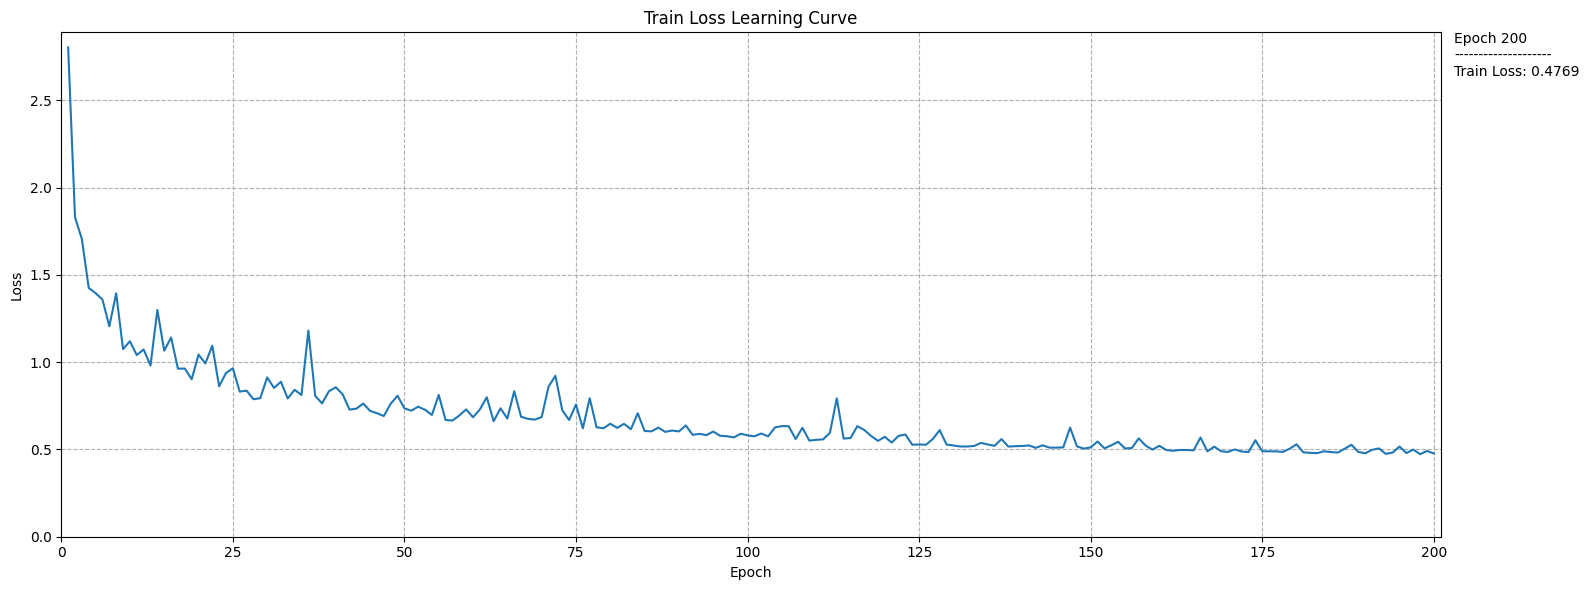

Epochs: 100%|██████████| 200/200 [03:52<00:00,  1.16s/epoch, Loss: 0.4769]


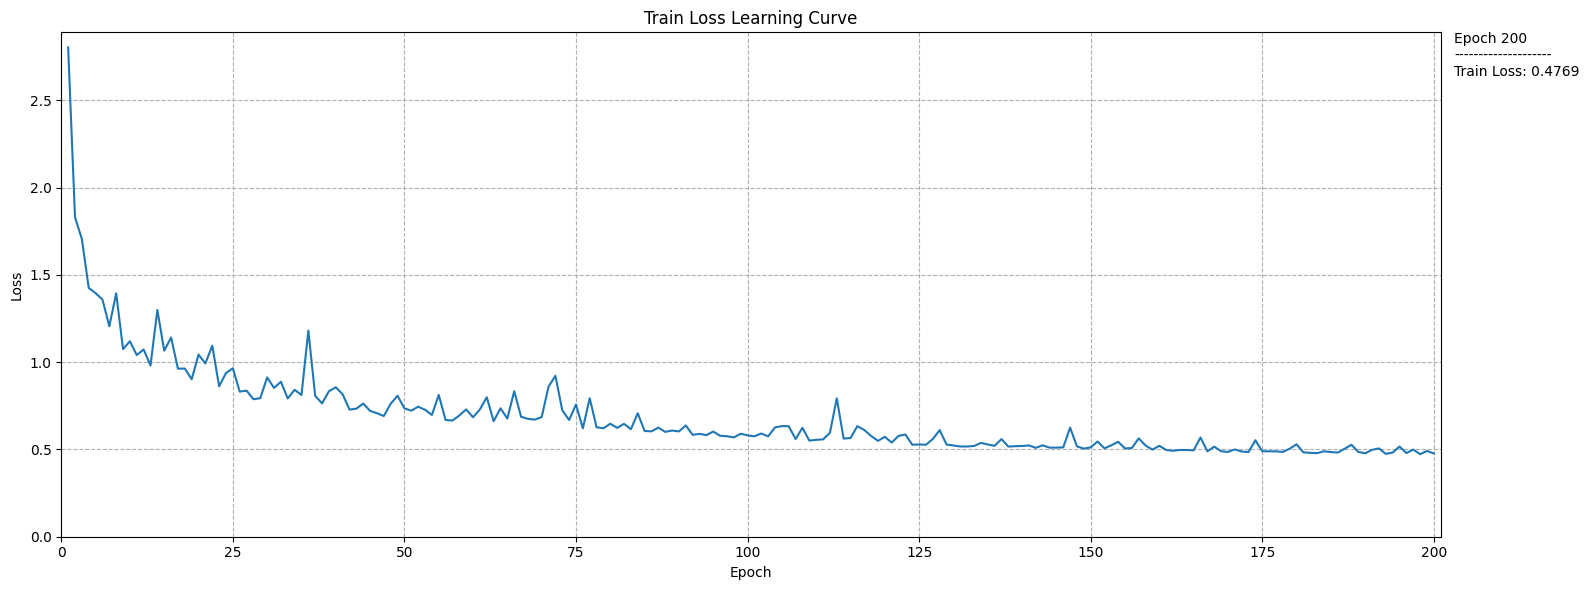

In [39]:
"""
Choose the configuration of your model and training
"""

model_config = dict(
    in_channels = 37,  
    hidden_channels = 512,  
    out_channels = 1,  
    )

# train_config = dict(
#     optimizer_name = "Adam",
#     optimizer_config = dict(lr = 1e-3, weight_decay = 2.5e-4),
#     lr_scheduler_name = "StepLR",
#     lr_scheduler_config = dict(step_size = 40, gamma = 0.67),
#     batch_size = 16,
#     n_epochs = 200,
#     )

train_config = dict(
    optimizer_name = "Adam",
    optimizer_config = dict(lr = 1e-3, weight_decay = 2.5e-4),
    lr_scheduler_name = "StepLR",
    lr_scheduler_config = dict(step_size = 40, gamma = 0.63),
    batch_size = 8,
    n_epochs = 200,
    )

if __name__ == '__main__':
    my_dataset = GraphDataset('data/train.npy')
    model = Model(**model_config)
    train(
        model = model,
        train_dataset = my_dataset,
        loss_fn = nn.MSELoss(),
        device = Device,
        plot_freq = 10,
        **train_config,
        )

# Zip submission files

You can run the following cell to zip the generated files for submission.

If you are on Colab, make sure to download and then upload a completed copy of the notebook to the working directory so the code can detect and include it in the zip file for submission.

In [40]:
save_yaml(model_config, 'model_config.yaml')
save_yaml(train_config, 'train_config.yaml')
torch.save(model.cpu().state_dict(), 'state_dict.pt')

# Test if the model can be loaded successfully
loaded_model = Model(**load_yaml('model_config.yaml')).cpu()
loaded_model.load_state_dict(torch.load('state_dict.pt', map_location='cpu'))

files_to_zip = ['HW5.ipynb', 'model_config.yaml', 'train_config.yaml', 'state_dict.pt']
output_zip = 'HW5_submission.zip'
zip_files(output_zip, *files_to_zip)

/tmp/ipykernel_119777/1520653395.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('state_dict.pt', map_location='cpu'))
